# PBRM1 cis comparison

"Involved in transcriptional activation and repression of select genes by chromatin remodeling (alteration of DNA-nucleosome topology). Required for the stability of the SWI/SNF chromatin remodeling complex SWI/SNF-B (PBAF). Acts as a negative regulator of cell proliferation (https://www.uniprot.org/uniprot/Q86U86).

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

In [8]:
def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests=1, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        #sites = len(comparison_columns.columns)
        number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = f.add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None

## Step 2: Find the mutation frequency of PBRM1 for Kidney Cancer

In [2]:
cancer = cptac.RenalCcrcc()
desired_cutoff = 0.1
gene = 'PBRM1'

freq_mut = al.get_frequently_mutated(cancer, cutoff = desired_cutoff)
freq_mut.loc[freq_mut['Gene'] == gene]

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
2,PBRM1,0.4,0.072727,0.336364


## Step 3: cis comparisons for omics 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

# Proteomics cis comparison

Proteomics: Mutated and Wildtype


In [10]:
# prepare for wrap_ttest_return_all
cis_tests = len(freq_mut) # adjust for multiple hypothesis testing (other genes compared in separate notebooks)

prot_col_list = [gene+'_proteomics']
prot_mut_status = f.format_cis_comparison_data(cancer, 'proteomics', gene)

In [12]:
# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(prot_mut_status, 'binary_mutations', prot_col_list, cis_tests)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,PBRM1_proteomics,1.657330e-10,True


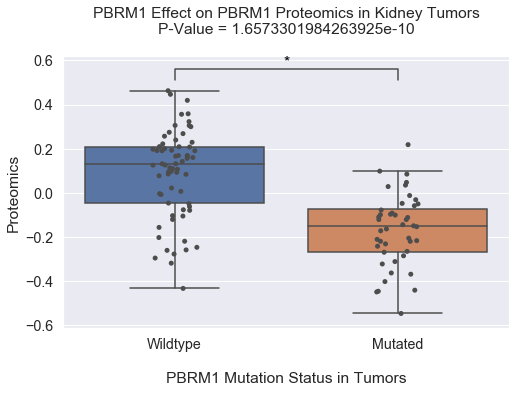

In [13]:
f.cis_plot(prot_mut_status, gene, "proteomics", prot_results)

Proteomics: Missense and Truncation compared to wildtype

In [14]:
prot_mut_type = f.get_missense_truncation_comparison(cancer, 'proteomics', gene)
prot_wildtype = prot_mut_status.loc[prot_mut_status['binary_mutations'] == 'Wildtype'] # select all wildtype 
prot_mut_and_wildtype = prot_mut_type.append(prot_wildtype, sort=False) # use for graph

In [15]:
# compare missense and wildtype
prot_miss_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Truncation']

print("Doing t-test comparison for missense and wildtype")
prot_results_miss = wrap_ttest_return_all(prot_miss_wt, 'binary_mutations', prot_col_list, cis_tests)
prot_results_miss = prot_results_miss.rename(index= {0: 'Missense/Wildtype'})
prot_results_miss

Doing t-test comparison for missense and wildtype


,Comparison,P_Value,Significant
Missense/Wildtype,PBRM1_proteomics,0.000136,True


In [16]:
# compare truncation and wildtype
prot_trunc_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Missense']

print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, cis_tests)
prot_results_trunc = prot_results_trunc.rename(index= {0: 'Truncation/Wildtype'})
prot_results_trunc

Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Truncation/Wildtype,PBRM1_proteomics,2.213882e-09,True


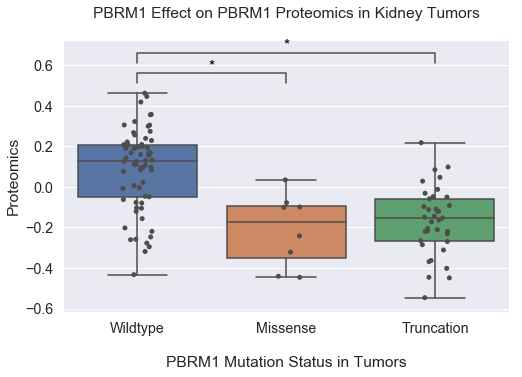

,Comparison,P_Value,Significant
Missense/Wildtype,PBRM1_proteomics,1.359037e-04,True
Truncation/Wildtype,PBRM1_proteomics,2.213882e-09,True


In [17]:
prot_results_miss_trunc = prot_results_miss.append(prot_results_trunc)
f.cis_plot(prot_mut_and_wildtype, gene, 'proteomics', prot_results_miss_trunc)

prot_results_miss_trunc

# Transcriptomics cis comparison

Transcriptomics: Mutated and Wildtype

In [18]:
trans_col_list = [gene+'_transcriptomics']
trans_mut_status = f.format_cis_comparison_data(cancer, 'transcriptomics', gene)

print("Doing t-test comparison for mutation status")
transcrpt_results = wrap_ttest_return_all(trans_mut_status, 'binary_mutations', trans_col_list)
transcrpt_results = transcrpt_results.rename(index = {0: "Mutated/Wildtype"})
transcrpt_results

Doing t-test comparison for mutation status


,Comparison,P_Value,Significant
Mutated/Wildtype,PBRM1_transcriptomics,0.000677,True


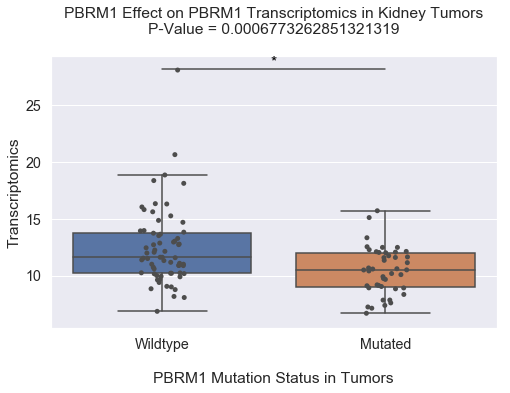

In [19]:
f.cis_plot(trans_mut_status, gene, 'transcriptomics', transcrpt_results)

Transcriptomics: Missense and Truncation

In [25]:
# select all wildtype from earlier -add to mut_type binary column
trans_wildtype = trans_mut_status.loc[trans_mut_status['binary_mutations'] == 'Wildtype'] 
trans_mut_type = f.get_missense_truncation_comparison(cancer, 'transcriptomics', gene)
trans_mut_and_wildtype = trans_mut_type.append(trans_wildtype, sort=False) # use for graph

In [26]:
# compare missense and wildtype
miss_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype")
trans_results_miss = wrap_ttest_return_all(miss_wt, 'binary_mutations', trans_col_list)
trans_results_miss = trans_results_miss.rename(index = {0: "Missense/Wildtype"})
trans_results_miss

Doing t-test comparison for missense and wildtype


,Comparison,P_Value,Significant
Missense/Wildtype,PBRM1_transcriptomics,0.26398,False


In [27]:
# compare truncation and wildtype
trunc_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
trans_results_trunc = wrap_ttest_return_all(trunc_wt, 'binary_mutations', trans_col_list)
trans_results_trunc = trans_results_trunc.rename(index = {0: "Truncation/Wildtype"})
trans_results_trunc

Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Truncation/Wildtype,PBRM1_transcriptomics,0.000526,True


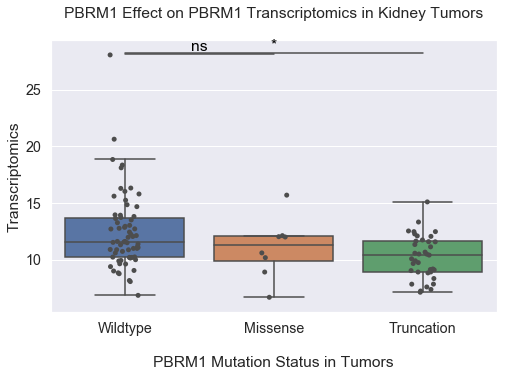

,Comparison,P_Value,Significant
Missense/Wildtype,PBRM1_transcriptomics,0.263980,False
Truncation/Wildtype,PBRM1_transcriptomics,0.000526,True


In [28]:
trans_results_miss_trunc = trans_results_miss.append(trans_results_trunc)
f.cis_plot(trans_mut_and_wildtype, gene, 'transcriptomics', trans_results_miss_trunc)

trans_results_miss_trunc

# Phosphoproteomics cis comparison

Phosphoproteomics: Mutated and Wildtype

In [29]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = cancer.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

# Step 2 - Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
omics_and_mut = omics_and_mut.query('Sample_Status != "Normal"') # changed because warning with slice
#tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = omics_and_mut.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)
#omics_and_mut['binary_mutations'].value_counts()

In [43]:
phos_col_list = list(only_phospho.columns)

# Use wrap_ttest for many columns of phosphoproteomics
# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status\n")
phos_pval_results = al.wrap_ttest(binary_phospho, 'binary_mutations', phos_col_list)
phos_pval_results

Doing t-test comparison for mutation status



,Comparison,P_Value
0,PBRM1-S526_phosphoproteomics,0.000003
1,PBRM1-S970_phosphoproteomics,0.000008
2,PBRM1-S519_phosphoproteomics,0.000026
3,PBRM1-S1152S1155_phosphoproteomics,0.000051
4,PBRM1-S34S35S37_phosphoproteomics,0.000153
5,PBRM1-S33S35_phosphoproteomics,0.000440


Graph

In [46]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison'])
phospho_df = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
#sig_phospho_df.dropna(axis=0)

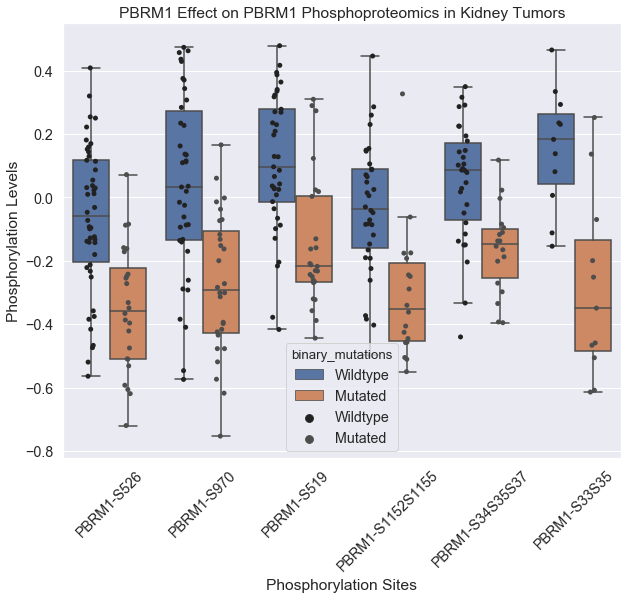

In [47]:
plt.rcParams['figure.figsize']=(10,8) #size of plot
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Kidney Tumors")
cis_boxplot = sns.stripplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels(),rotation = 45)
plt.show()
plt.clf()
plt.close()

Phosphoproteomics: Missense and Truncation

In [48]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype = binary_phospho.loc[binary_phospho['binary_mutations'] == 'Wildtype'] 

phos_mut_type = f.get_missense_truncation_comparison(cancer, 'phosphoproteomics', gene)
phos_mut_and_wildtype = phos_mut_type.append(phos_wildtype, sort=True) 

In [52]:
phos_col_list = list(only_phospho.columns)
# compare missense and wildtype
miss_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype")
phos_results_miss = al.wrap_ttest(miss_wt, 'binary_mutations', phos_col_list)
phos_results_miss

Doing t-test comparison for missense and wildtype
No significant comparisons.


In [59]:
# compare truncation and wildtype 
trunc_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
phos_results_trunc = al.wrap_ttest(trunc_wt, 'binary_mutations', phos_col_list)
phos_results_trunc

Doing t-test comparison for truncation and wildtype


,Comparison,P_Value
0,PBRM1-S970_phosphoproteomics,0.000011
1,PBRM1-S526_phosphoproteomics,0.000021
2,PBRM1-S519_phosphoproteomics,0.000038
3,PBRM1-S1152S1155_phosphoproteomics,0.000063
4,PBRM1-S34S35S37_phosphoproteomics,0.000175
5,PBRM1-S33S35_phosphoproteomics,0.000628


In [60]:
# Create data frame with all significant phospho sites for missense comparison
sig_trunc_col = list(phos_results_trunc['Comparison'])
phos_trunc_df = pd.melt(phos_mut_and_wildtype, id_vars = 'binary_mutations', 
            value_vars = sig_trunc_col, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phos_trunc_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names

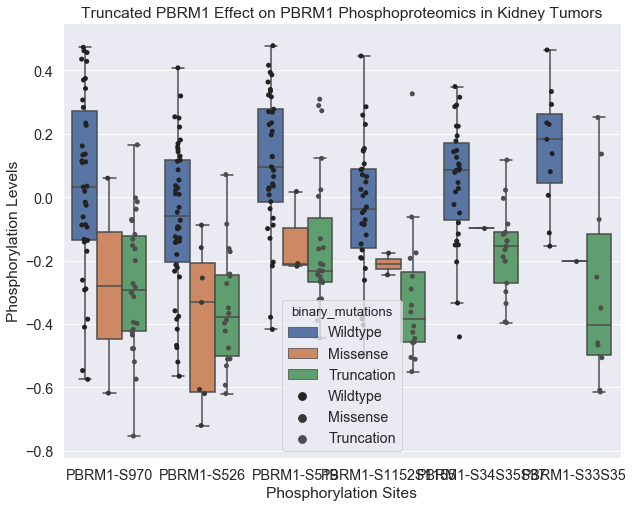

In [61]:
plt.rcParams['figure.figsize']=(10,8) #size of plot
sns.set(font_scale = 1.3)
phos_cis_boxplot = sns.boxplot(data = phos_trunc_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Missense","Truncation"], showfliers = False)  
phos_cis_boxplot.set_title("Truncated "+gene + " Effect on " + gene + " Phosphoproteomics in Kidney Tumors")
phos_cis_boxplot = sns.stripplot(data = phos_trunc_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Missense","Truncation"], jitter = True, color = ".3", dodge=True)
phos_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
phos_cis_boxplot.set_xticklabels(phos_cis_boxplot.get_xticklabels())
plt.show()
plt.clf()
plt.close()

# Analysis of Results

Proteomics decrease for both missense and truncation mutations in PBRM1. Transcriptomics and phosphorylation levels also decrease with truncation mutations.

No acetylproteomics for the kidney dataset.